# AI Training with AutoML approach

Results are based on current preprocessing, which is not finished yet.

In [45]:
#Imports:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import autokeras as ak

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from imblearn.over_sampling import SMOTE 


In [16]:
# Methods to test the predictions

def count_points(pred, gold):
    df = pd.merge(pred, gold, on=['userID', 'itemID'], suffixes=('_pred', '_gold'))
    df['points'] = df.apply(_compute_points_for_row, axis=1)
    return df['points'].sum()

def _compute_points_for_row(row):
    y_pred, y_gold = row.prediction_pred, row.prediction_gold
    if y_pred == y_gold:
        # one point if "no order" (0) is predicted correctly; three points if order week is predicted correctly
        return 1 if y_pred == 0 else 3
    # one point if order is predicted correctly (but not the correct week), otherwise zero points
    return 1 if (y_pred > 0 and y_gold > 0) else 0

### Load data with small preprocessing

In [51]:
#loading the datasets 

df_orders = pd.read_csv("orders__dec_labeled.csv", sep = ",") #labeled
df_items = pd.read_csv("items.csv", sep = "|") #items
df_category = pd.read_csv("category_hierarchy.csv", sep = "|") #categories

df_orders

,date,userID,itemID,order,label
0,2020-12-01,40058,860,1,0
1,2020-12-01,44334,11344,1,0
2,2020-12-01,17410,4049,1,0
3,2020-12-01,8713,25993,1,0
4,2020-12-01,12889,9376,1,0
...,...,...,...,...,...
138745,2020-12-31,3100,5768,1,0
138746,2020-12-31,11941,11798,2,0
138747,2020-12-31,1730,352,1,0
138748,2020-12-31,22593,18515,1,0


In [52]:
print(len(df_items['itemID'].unique())) #checking for duplicates
print(len(df_items))

32776
32776


In [53]:
result = pd.merge(df_orders, df_items, on="itemID") #merging the dataset on itemID 

In [54]:
result = result.drop(['categories'], axis = 1) #dropping the categories
result = result.drop(['date'], axis = 1) # dropping the date

labels = result["label"] # generating a label dataset
data = result.drop(['label'], axis = 1) #dropping label

data

,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5
0,40058,860,1,829,4,0,484,0,144
1,23826,860,1,829,4,0,484,0,144
2,37503,860,1,829,4,0,484,0,144
3,8638,860,1,829,4,0,484,0,144
4,44334,11344,1,177,10,0,503,0,122
...,...,...,...,...,...,...,...,...,...
138745,34906,21985,1,203,4,1,491,3,66
138746,15170,10084,1,1445,3,0,-1,-1,-1
138747,30587,9338,1,322,4,1,536,0,144
138748,30587,29204,1,342,6,1,232,0,122


In [55]:
enc = OneHotEncoder(handle_unknown='ignore') #onehotencoder
cols = ["feature_1", "feature_2", "feature_4"] #columns to onehot encode
enc.fit(data[cols])
encoder_df = pd.DataFrame(enc.transform(data[cols]).toarray()) #encoding
data = data[["userID", "itemID", "brand", "feature_3", "feature_5", "order"]].join(encoder_df) #merging


In [56]:
data

,userID,itemID,brand,feature_3,feature_5,order,0,1,2,3,...,11,12,13,14,15,16,17,18,19,20
0,40058,860,829,484,144,1,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,23826,860,829,484,144,1,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,37503,860,829,484,144,1,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,8638,860,829,484,144,1,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,44334,11344,177,503,122,1,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138745,34906,21985,203,491,66,1,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
138746,15170,10084,1445,-1,-1,1,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
138747,30587,9338,322,536,144,1,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
138748,30587,29204,342,232,122,1,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [57]:
#orders = np.array(orders)
#data = np.array(data)
print(labels)
#lenc = LabelEncoder()
#lenc = lenc.fit(labels)
#labels = lenc.transform(labels)
#labels = np.array(labels).reshape(-1,1)

0         0
1         0
2         0
3         0
4         0
         ..
138745    0
138746    0
138747    0
138748    0
138749    0
Name: label, Length: 138750, dtype: int64


array([[<AxesSubplot:title={'center':'label'}>]], dtype=object)

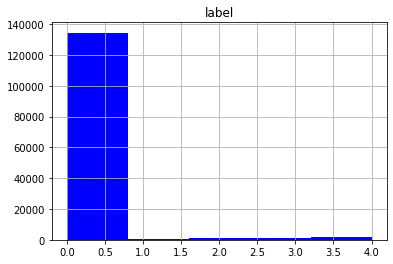

In [58]:
pd.DataFrame(labels).hist(bins=5,color='blue' ) #plot histogram

In [59]:
X_train, X_test, y_train, y_test = train_test_split( data, labels, test_size=0.1, random_state=42) #split data in test and train

combinedData = pd.DataFrame(X_train).copy() #combine train for samling
combinedData["label"] = pd.DataFrame(y_train)
combinedData

,userID,itemID,brand,feature_3,feature_5,order,0,1,2,3,...,12,13,14,15,16,17,18,19,20,label
114185,33029,26798,1232,282,146,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
20133,17476,24512,193,453,108,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
1954,9385,6654,1496,359,97,2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
119751,12384,21787,206,503,101,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
20485,14496,17089,186,17,81,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110268,22891,20612,1368,468,76,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
119879,26059,20933,393,491,66,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
103694,7707,1650,322,536,144,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
131932,30705,4332,1180,97,53,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0


In [60]:
sm = SMOTE(random_state=42)
X_train, y_train=  sm.fit_resample(X_train, y_train)

X_train = np.array(X_train)
y_train = np.array(y_train)

C:\Users\knabp_000\anaconda3\envs\Envi\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [61]:
X_train, X_val, y_train, y_val= train_test_split( X_train, y_train, test_size=0.1, random_state=42)
print(len(X_train.shape), len(X_test.shape), len(X_val.shape))
X_train.shape

2 2 2


(544608, 27)

In [64]:
y_train

array([4, 1, 4, ..., 3, 1, 0], dtype=int64)

### AutoML Training

We use Autokeras to train the AI, which uses DL libraries.

In [65]:
model = ak.AutoModel(
    inputs=[ak.StructuredDataInput()],
    outputs=[ak.RegressionHead()],
    max_trials=5,
    overwrite = True
)


In [ ]:
model.fit(
    x=X_train, y=y_train, epochs=100, batch_size=128, validation_data= [X_val, y_val]
)


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
False             |?                 |structured_data_block_1/normalize
False             |?                 |structured_data_block_1/dense_block_1/use_batchnorm
2                 |?                 |structured_data_block_1/dense_block_1/num_layers
32                |?                 |structured_data_block_1/dense_block_1/units_0
0                 |?                 |structured_data_block_1/dense_block_1/dropout
32                |?                 |structured_data_block_1/dense_block_1/units_1
0                 |?                 |regression_head_1/dropout
adam              |?                 |optimizer
0.001             |?                 |learning_rate

Epoch 1/100
4255/4255 [==============================] - 6s 1ms/step - loss: 6530.9663 - mean_squared_error: 6530.9663 - val_loss: 15.4579 - val_mean_squared_error: 15.4579
Epoch 2/100
4255/4255 [==============================] - 5s 1ms/step - loss: 111.

In [16]:
model = model.export_model()


try:
    model.save("model_autokeras", save_format="tf")
except Exception:
    model.save("model_autokeras.h5")

INFO:tensorflow:Assets written to: model_autokeras\assets


### Testing the model

In [27]:
to_test = X_val
truth = y_val

res = np.round(model.predict(to_test))
info = pd.DataFrame(to_test)
stand = pd.DataFrame()
stand["userID"] = info[[0]]
stand["itemID"] = info[[1]]
pred = stand.copy()
gold = stand.copy()
pred["prediction"] = np.round(res)#lenc.inverse_transform((res.astype(int))))
gold["prediction"] = np.round(truth)

In [29]:
points = count_points(pred, gold)
max_points = count_points(gold, gold)
score = points / max_points

In [30]:
print(points)
print(max_points)
print(score)

1141
1239
0.9209039548022598


### Applying model on new Data

In [81]:
name = 'submission_jan'

df_submission = pd.read_csv( name+".csv", sep = "|")

result_pred = pd.merge(df_submission, df_items, on="itemID")

result_pred = result_pred.drop(['categories'], axis = 1)
data = result_pred.drop(['prediction'], axis = 1)
                        
cols = ["feature_1", "feature_2", "feature_4"]

encoder_df = pd.DataFrame(enc.transform(data[cols]).toarray())
data = data[["userID", "itemID", "brand", "feature_3", "feature_5"]].join(encoder_df)

data

,userID,itemID,brand,feature_3,feature_5,0,1,2,3,4,...,11,12,13,14,15,16,17,18,19,20
0,0,20664,408,284,66,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,23363,20664,408,284,66,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0,28231,193,468,108,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,13,2690,406,491,66,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,15,1299,1056,474,108,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9935,46049,17984,449,207,45,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9936,46069,29992,280,484,44,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9937,46117,8847,143,46,69,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9938,46124,19677,1006,491,154,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [82]:
res = np.round(model.predict(np.array(data)))
df = pd.DataFrame()
df["prediction"] = pd.DataFrame(np.int_(res))
df

,prediction
0,0
1,0
2,0
3,0
4,0
...,...
9935,0
9936,0
9937,0
9938,0


array([[<AxesSubplot:title={'center':'prediction'}>]], dtype=object)

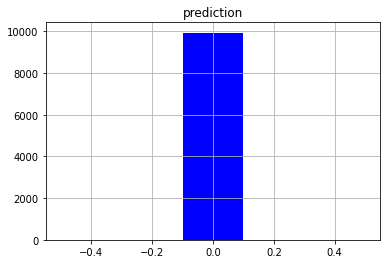

In [83]:
df.hist(bins=5,color='blue' )

In [84]:
df.sort_values(by = ["prediction"],ascending=False)

,prediction
0,0
6630,0
6623,0
6624,0
6625,0
...,...
3313,0
3314,0
3315,0
3316,0


In [85]:
df_submission["prediction"] = df["prediction"]
df_submission

,userID,itemID,prediction
0,0,20664,0
1,0,28231,0
2,13,2690,0
3,15,1299,0
4,15,20968,0
...,...,...,...
9935,46118,20106,0
9936,46124,19677,0
9937,46125,12878,0
9938,46127,7963,0


In [86]:
df_submission.to_csv(name+"_pred.csv", sep='|')